In [9]:
import pandas as pd

df_energia21 = pd.read_csv('energia_202109-202112.csv', encoding='latin-1', keep_default_na=False) # keep_default_na=False para que o "None" apareca na injecao inves de "NAN"
df_energia22 = pd.read_csv('energia_202201-202212.csv', encoding='latin-1', keep_default_na=False)
df_energia_teste = pd.read_csv('energia_202301-202304.csv', encoding='latin-1')

df_meteo21 = pd.read_csv('meteo_202109-202112.csv', encoding='latin-1')
df_meteo22 = pd.read_csv('meteo_202201-202212.csv', encoding='latin-1')
df_meteo_teste = pd.read_csv('meteo_202301-202304.csv', encoding='latin-1')

In [10]:
df_energia_merged = pd.concat([df_energia21, df_energia22], ignore_index=True)
df_meteo_merged = pd.concat([df_meteo21, df_meteo22], ignore_index=True)

In [11]:
df_energia_merged['DataHora'] = pd.to_datetime(df_energia_merged['Data'] + ' ' + df_energia_merged['Hora'].astype(str) + ':00:00')
df_meteo_merged['DataHora'] = pd.to_datetime(df_meteo_merged['dt_iso'].str.replace(' +0000 UTC', '', regex=False))

In [12]:
df_merged = pd.merge(df_energia_merged, df_meteo_merged, on='DataHora', how='outer')

# Reordena as colunas para por DataHora como a primeira
cols = ['DataHora'] + [col for col in df_merged.columns if col != 'DataHora']
df_merged = df_merged[cols]

Epoch 1/30


c:\Users\games\anaconda3\envs\lcd_scaa\Lib\site-packages\sklearn\utils\extmath.py:1101: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
c:\Users\games\anaconda3\envs\lcd_scaa\Lib\site-packages\sklearn\utils\extmath.py:1106: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
c:\Users\games\anaconda3\envs\lcd_scaa\Lib\site-packages\sklearn\utils\extmath.py:1126: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count
c:\Users\games\anaconda3\envs\lcd_scaa\Lib\site-packages\keras\src\layers\core\dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


496/496 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.7052 - loss: 1.4124 - val_accuracy: 0.7029 - val_loss: 1.2495
Epoch 2/30
496/496 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7063 - loss: 1.1537 - val_accuracy: 0.7029 - val_loss: 1.0832
Epoch 3/30
496/496 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.7063 - loss: 1.0468 - val_accuracy: 0.7029 - val_loss: 1.0207
Epoch 4/30
496/496 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.7063 - loss: 1.0102 - val_accuracy: 0.7029 - val_loss: 0.9996
Epoch 5/30
496/496 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.7063 - loss: 0.9990 - val_accuracy: 0.7029 - val_loss: 0.9918
Epoch 6/30
496/496 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7063 - loss: 0.9957 - val_accuracy: 0.7029 - val_loss: 0.9884
Epoch 7/30
496/496 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7063 - loss: 0.9946 - val_accuracy: 0.7029 - val_loss: 0.9863
Epoch 8/30
496/496 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7063 - loss: 0.9942 - val_accuracy: 0.7029 - val_

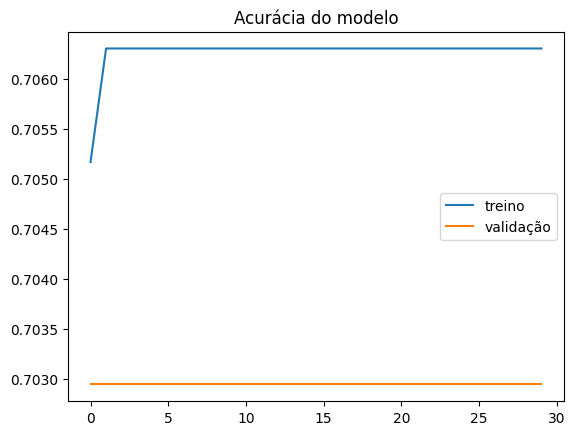

In [13]:
import tensorflow as tf
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
import matplotlib.pyplot as plt

# garantir que os dados já estão carregados
df = df_merged.copy()

# coluna alvo (texto)
target_col = "Injeção na rede (kWh)"

# remover linhas com alvo ausente
df = df.dropna(subset=[target_col])

# codificar alvo (ex: "None", "Low", "High")
encoder = LabelEncoder()
y = encoder.fit_transform(df[target_col])

# selecionar apenas colunas numéricas como entrada
X = df.select_dtypes(include=[np.number]).copy()

# eliminar colunas redundantes se existirem
cols_invalidas = ["dt", "dt_iso"]
X = X.drop(columns=[c for c in cols_invalidas if c in X.columns], errors="ignore")

# normalizar
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# dividir treino/teste
x_train, x_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42, stratify=y
)

# número de classes
n_classes = len(np.unique(y))

# modelo MLP classificação
model = tf.keras.Sequential([
    tf.keras.layers.Dense(64, activation='relu', input_shape=(x_train.shape[1],)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(n_classes, activation='softmax')
])

# compilar
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# treinar
history = model.fit(x_train, y_train, epochs=30, batch_size=16,
                    validation_split=0.1, verbose=1)

# avaliar
loss, acc = model.evaluate(x_test, y_test)
print("\nAcurácia no teste:", acc)

# prever
preds = model.predict(x_test[:10])
pred_classes = np.argmax(preds, axis=1)

for i, p in enumerate(pred_classes):
    print(f"Previsto: {encoder.inverse_transform([p])[0]} | Real: {encoder.inverse_transform([y_test[i]])[0]}")

# gráfico de desempenho
plt.plot(history.history['accuracy'], label='treino')
plt.plot(history.history['val_accuracy'], label='validação')
plt.legend()
plt.title("Acurácia do modelo")
plt.show()


Epoch 1/50
248/248 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.7163 - loss: 0.8566 - val_accuracy: 0.8197 - val_loss: 0.5198
Epoch 2/50
248/248 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8011 - loss: 0.5416 - val_accuracy: 0.8209 - val_loss: 0.4639
Epoch 3/50
248/248 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8121 - loss: 0.4886 - val_accuracy: 0.8209 - val_loss: 0.4351
Epoch 4/50
248/248 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8202 - loss: 0.4484 - val_accuracy: 0.8197 - val_loss: 0.4125
Epoch 5/50
248/248 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8201 - loss: 0.4340 - val_accuracy: 0.8220 - val_loss: 0.4077
Epoch 6/50
248/248 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8262 - loss: 0.4078 - val_accuracy: 0.8288 - val_loss: 0.3913
Epoch 7/50
248/248 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8260 - loss: 0.4000 - val_accuracy: 0.8356 - val_loss: 0.3860
Epoch 8/50
248/248 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8362 - loss: 0.3979 - val_accuracy: 0.

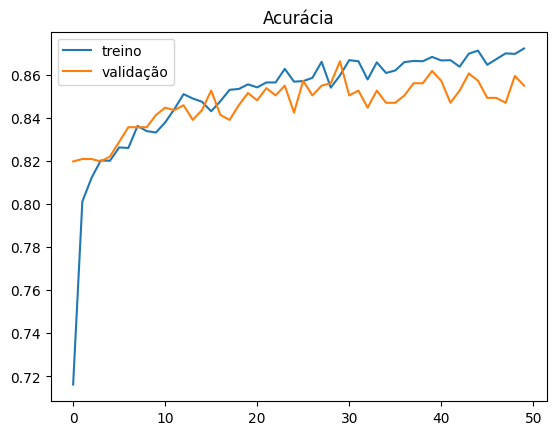

In [7]:
import tensorflow as tf
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
import matplotlib.pyplot as plt

df = df_merged.copy()

# alvo
target_col = "Injeção na rede (kWh)"
df = df.dropna(subset=[target_col])

# codificar alvo
encoder = LabelEncoder()
y = encoder.fit_transform(df[target_col])

# apenas colunas numéricas
X = df.select_dtypes(include=[np.number]).copy()

# remover colunas problemáticas
X = X.drop(columns=[c for c in ["dt", "dt_iso"] if c in X.columns], errors="ignore")

# substituir inf e nan
X = X.replace([np.inf, -np.inf], np.nan)
X = X.fillna(0)

# normalizar
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# divisão
x_train, x_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42, stratify=y
)

n_classes = len(np.unique(y))

# modelo com normalização e dropout
model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(x_train.shape[1],)),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(n_classes, activation='softmax')
])

# compilar
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# treino
history = model.fit(x_train, y_train, epochs=50, batch_size=32,
                    validation_split=0.1, verbose=1)

# avaliação
loss, acc = model.evaluate(x_test, y_test)
print("\nAcurácia no teste:", acc)

# previsões
preds = model.predict(x_test[:10])
pred_classes = np.argmax(preds, axis=1)
for i, p in enumerate(pred_classes):
    print(f"Previsto: {encoder.inverse_transform([p])[0]} | Real: {encoder.inverse_transform([y_test[i]])[0]}")

# gráfico
plt.plot(history.history['accuracy'], label='treino')
plt.plot(history.history['val_accuracy'], label='validação')
plt.legend()
plt.title("Acurácia")
plt.show()


In [8]:
df_energia_teste['DataHora'] = pd.to_datetime(df_energia_teste['Data'] + ' ' + df_energia_teste['Hora'].astype(str) + ':00:00')
df_meteo_teste['DataHora'] = pd.to_datetime(df_meteo_teste['dt_iso'].str.replace(' +0000 UTC', '', regex=False))

In [ ]:
df_final = pd.merge(df_energia_teste, df_meteo_teste, on='DataHora', how='outer')

# Reordena as colunas para por DataHora como a primeira
cols = ['DataHora'] + [col for col in df_final.columns if col != 'DataHora']
df_final = df_final[cols]

In [24]:
prev1 = pd.read_csv('predicoes_injecao.csv', keep_default_na=False)
prev2 = pd.read_csv("C:/Users/games/Downloads/predicoes_injecao (2).csv", keep_default_na=False)
prev2

,RowId,Result
0,1,None
1,2,None
2,3,None
3,4,None
4,5,None
...,...,...
2251,2252,None
2252,2253,None
2253,2254,None
2254,2255,None


In [25]:
col = 'Result'  # nome da coluna a comparar

comparacao = prev1[col] == prev2[col]
iguais = comparacao.sum()
total = len(comparacao)
percent_iguais = 100 * iguais / total

print(f"Iguais: {iguais}/{total} ({percent_iguais:.2f}%)")


Iguais: 2013/2256 (89.23%)


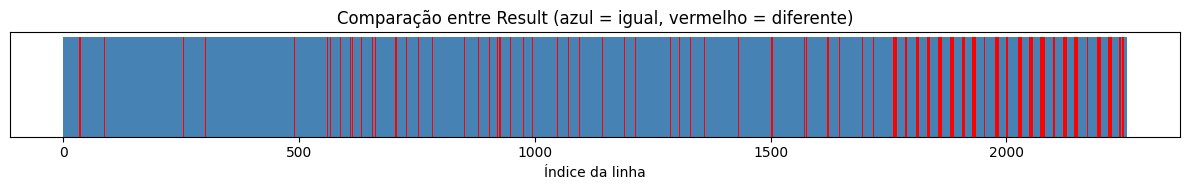

In [31]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

col = 'Result'
iguais = prev1[col] == prev2[col]

# mapa de cores
cores = np.where(iguais, 'steelblue', 'red')

# gráfico
plt.figure(figsize=(12, 2))
plt.bar(range(len(iguais)), [1]*len(iguais), color=cores, width=1)
plt.title('Comparação entre Result (azul = igual, vermelho = diferente)')
plt.xlabel('Índice da linha')
plt.yticks([])
plt.tight_layout()
plt.show()
